## Group Members
Federico Angelo Mor   
Federica Rena   
Giulia Mezzadri   
Abylaikhan Orynbassar   
Oswaldo Jesus Morales Lopez    
Ettore Modina   

# Analyzing HIV Drug Resistance

We consider the dataset data set publicly available from the Stanford [HIV Drug Resistance Database][1]

<!-- References -->
[1]: https://hivdb.stanford.edu/pages/published_analysis/genophenoPNAS2006/

In [1]:
# Install cmdstanpy module
!pip install cmdstanpy

# Install arviz module (With version 2.33.1 you will need a special version of arviz)
!pip install git+https://github.com/OriolAbril/arviz.git@ci

  Cloning https://github.com/OriolAbril/arviz.git (to revision ci) to /tmp/pip-req-build-vel60v8i
  Running command git clone --filter=blob:none --quiet https://github.com/OriolAbril/arviz.git /tmp/pip-req-build-vel60v8i
  Running command git checkout -b ci --track origin/ci
  Switched to a new branch 'ci'
  Branch 'ci' set up to track remote branch 'ci' from 'origin'.
  Resolved https://github.com/OriolAbril/arviz.git to commit 7c20182c25b0b5e9af8242d1ee4d1185ae82b70a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for arviz: filename=arviz-0.17.0.dev0-py3-none-any.whl size=1651461 sha256=44635e0f1298a7503ecfae678041742ddaab587536f94685085bc78ea270d1b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5f3u86m/wheels/46/1e/6c/46b9c646a79d4a0f01b37df1c2c0abcc4e7129fe66e88e9b0f
Successfully built arviz
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Unin

In [2]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan,set_make_env
# set_make_env("mingw32-make.exe") # On Windows with mingw32-make
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.33.1
Download successful, file: /tmp/tmpt6zqr7zl
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.33.1
Building version cmdstan-2.33.1, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.33.1
Test model compilation


True

In [3]:
# Import modules
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Import functions
from cmdstanpy import CmdStanModel
from scipy.optimize import fsolve
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

In [6]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive
sample_data/  stan/


In [16]:
# %cd "/gdirve/My Drive/"
%cd "/gdrive/My Drive/anndl challenges/"
%cd "../Colab Notebooks/Interactive T.A. 2"
%ls

/gdrive/My Drive/anndl challenges
/gdrive/My Drive/Colab Notebooks/Interactive T.A. 2
SparseRegressionModeling.ipynb  stan/  X.csv  Y.csv


In [109]:
# Import responses
Y_full = pd.read_csv("Y.csv", index_col=0)
Y_full.head()

,APV,ATV,IDV,LPV,NFV,RTV,SQV
1,2.3,NaN,32.7,NaN,23.4,51.6,37.8
2,76.0,NaN,131.0,200.0,50.0,200.0,156.0
3,2.8,NaN,12.0,NaN,100.0,41.0,145.6
4,6.5,9.2,2.1,5.3,5.0,36.0,13.0
5,8.3,NaN,100.0,NaN,161.1,170.2,100.0


In [110]:
# Import covariates
X = pd.read_csv("X.csv", index_col=0)
X.head()

,P4.A,P12.A,P13.A,P16.A,P20.A,P22.A,P28.A,P37.A,P51.A,P54.A,...,P16.Z,P18.Z,P19.Z,P34.Z,P37.Z,P61.Z,P72.Z,P79.Z,P83.Z,P92.Z
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
print(X.shape)
print(Y_full.shape)

(846, 361)
(846, 7)


The features (columns of $X$) are given by mutation/position pairs. Define
\begin{array}{ll}
    X_{i,j} & \text{1 if the $i$th patient has the $j$th mutation/position pair and 0 otherwise}, \\
    Y_{i,k} & \text{resistance of patient $i$ to drug $k$}.
\end{array}
For example, in the dataset, three different mutations (A, C, and D) are observed at position 63 in the protease, and so three columns of $X$ (named P63.A, P63.C, and P63.D) indicate the presence or absence of each mutation at this position.

For the moment, consider only the 1st drug, i.e. the first column of $Y$ let the response $y_i$ be a suitable transformation of such values.

## Select data and discard missing values

In [111]:
# Get first column and discard NaNs from Y and X
# Check NaN
nan_X = np.isnan(X)
nan_X # no nan in X
nan_Y = np.isnan(Y_full)
nan_Y # no nan in Y_full

# Save covariates names
cov_X = X.columns.tolist()
cov_X
cov_Y = Y_full.columns.tolist()
cov_Y

# Get first column and discard NaNs from Y and X
temp = X
temp['APV'] = Y_full['APV'].values
temp = temp.dropna()
X = temp.values[:,0:-1]
Y = temp.values[:,-1]

In [87]:
print(X.shape)
print(Y.shape)

(767, 361)
(767,)


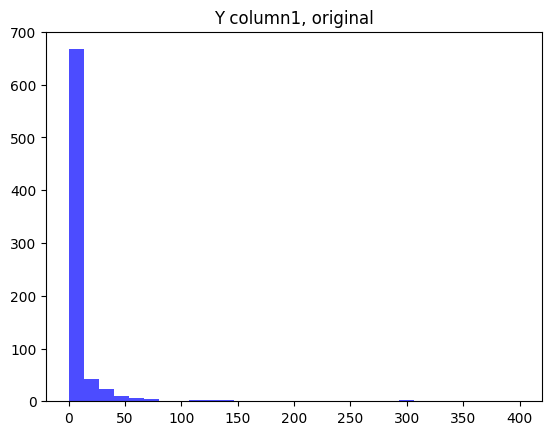

In [112]:
# Plot data
plt.hist(Y, bins=30, color='blue', alpha=0.7)
plt.title('Y column1, original')
plt.show()

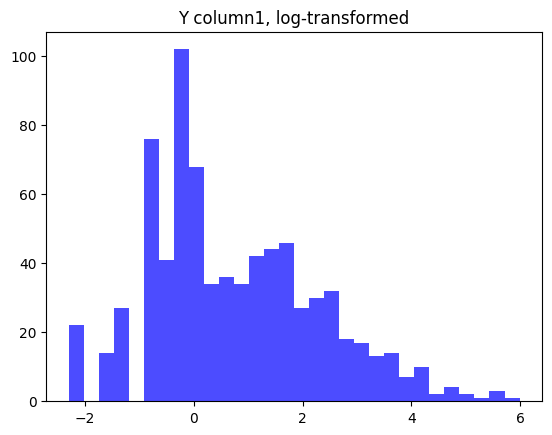

In [113]:
# Transform data
plt.hist(np.log(Y), bins=30, color='blue', alpha=0.7)
plt.title('Y column1, log-transformed')
plt.show()

## Sparse regression priors
$\newcommand{\iid}{\stackrel{\tiny\mbox{iid}}{\sim}}$
We assume a linear model:

$$
    y_i = \alpha + x_i^T \beta + \varepsilon_i, \quad \varepsilon_i \iid \mathcal{N}(0, \sigma^2)
$$

and consider several possible prior specifications for $\beta$

1. Gaussian:
   \begin{equation*}
       \beta \sim \mathcal{N}(0, \tau I) \tag{1}
   \end{equation*}

2. The Bayesian Lasso:
    \begin{equation*}
        \beta_j \sim \mathcal{DE}(0, \tau) \tag{2}
    \end{equation*}
    where $\mathcal{DE}$ denotes the Double Exponential or Laplace distribution.

3. The spike-and-slab prior by [Ishwaran and Rao (2005)][1]:
    \begin{align*}
        \beta_j \mid p_j & \sim p_j \mathcal{N}(0, \tau_1) + (1 - p_j) \mathcal{N}(0, \tau_2) \\ \tag{3}
        p_j & \sim \text{Bern}(0.5)
    \end{align*}
   Here $\tau_1 \ll \tau_2$.

4. The spike-and-slab Lasso:
   \begin{align*}
       \beta_j \mid p_j &\sim p_j \mathcal{DE}(0, \tau_1) + (1 - p_j) \mathcal{DE}(0, \tau_2) \\ \tag{4}
       p_j &\sim \text{Bern}(0.5)
    \end{align*}
   Here $\tau_1 \ll \tau_2$.

5. The Horseshoe:
    \begin{align*}
        \beta_j \mid \lambda_j, \tau & \sim \mathcal{N}(0, \lambda_j^2 \tau) \\ \tag{5}
        \lambda_j &\sim \mathcal{HC}(0, 1)
    \end{align*}

6. The finnish (or regularised) Horseshoe
    \begin{align*}
        \beta_j \mid \lambda_j, \tau, c & \sim \mathcal{N}(0, \widetilde \lambda_j^2 \tau), \\ \tag{6}
        \widetilde \lambda_j^2 &= \frac{c^2\lambda_j^2}{c^2 + \tau^2 \lambda_j^2} \\
        \lambda_j &\sim \mathcal{HC}(0, 1) \\
        c & \sim \text{Inv-Gamma}(a, b)
    \end{align*}

<!-- References -->
[1]: https://projecteuclid.org/journals/annals-of-statistics/volume-33/issue-2/Spike-and-slab-variable-selection-Frequentist-and-Bayesian-strategies/10.1214/009053604000001147.full

## Exercise 1:

1) Plot the marginal distribution of $\beta_j$ under the different priors.
   *Hint: if you cannot marginalize out latent variable analytically, you can use Monte Carlo simulation*.

2) Remember the usual analogy between the penalized MLE (maximul log likelihood estimator) and the MAP (maximum a posteriori). In fact:
   $$
       \log \pi(\beta \mid \mathbf{y}) \propto \sum_{i=1}^n \ell(y_i \mid \beta) + \log \pi(\beta)
   $$
   where $\ell(y_i \mid \beta)$ it the log-likelihood for the $i$-th datum.  
   Some priors can be seen as analogous to "famous" penalties in the frequentist literature. Can you recognize them?


3) It is often useful to interpret the frequentist penalties in terms of the norm of the vector $\beta$. For instance, for ridge regression the penalty is
   $$
       \lambda \|\beta \|_2^2
   $$
   Given a particular penalty, it is interesting to look at the "unit ball" of the corresponding norm when the dimension of $\beta$ is equal to 2, i.e. plotting the set
   $$
       \{ \beta_1, \beta_2 \in \mathbb R: \|\beta \|_\pi = 1 \}
   $$
   where $\| \cdot \|_\pi$ is the norm associated to the prior / penalty in the regression.  
   Approximating  the log density of $\beta_j$ under the Horseshoe with the lower bound from [Carvalho et al (2010)][1] for
   $$
       \log \pi(\beta_j \mid \tau) \geq - \log \log \left(1 + \frac{2 \tau^2}{\beta_j^2} \right)
   $$
   plot the unit-ball according to the penalties associated to priors $(1)$, $(2)$ and $(5)$.

<!-- References -->
[1]: https://www.jstor.org/stable/25734098

### Solution

**Plots - Marginal prior for $\beta$**

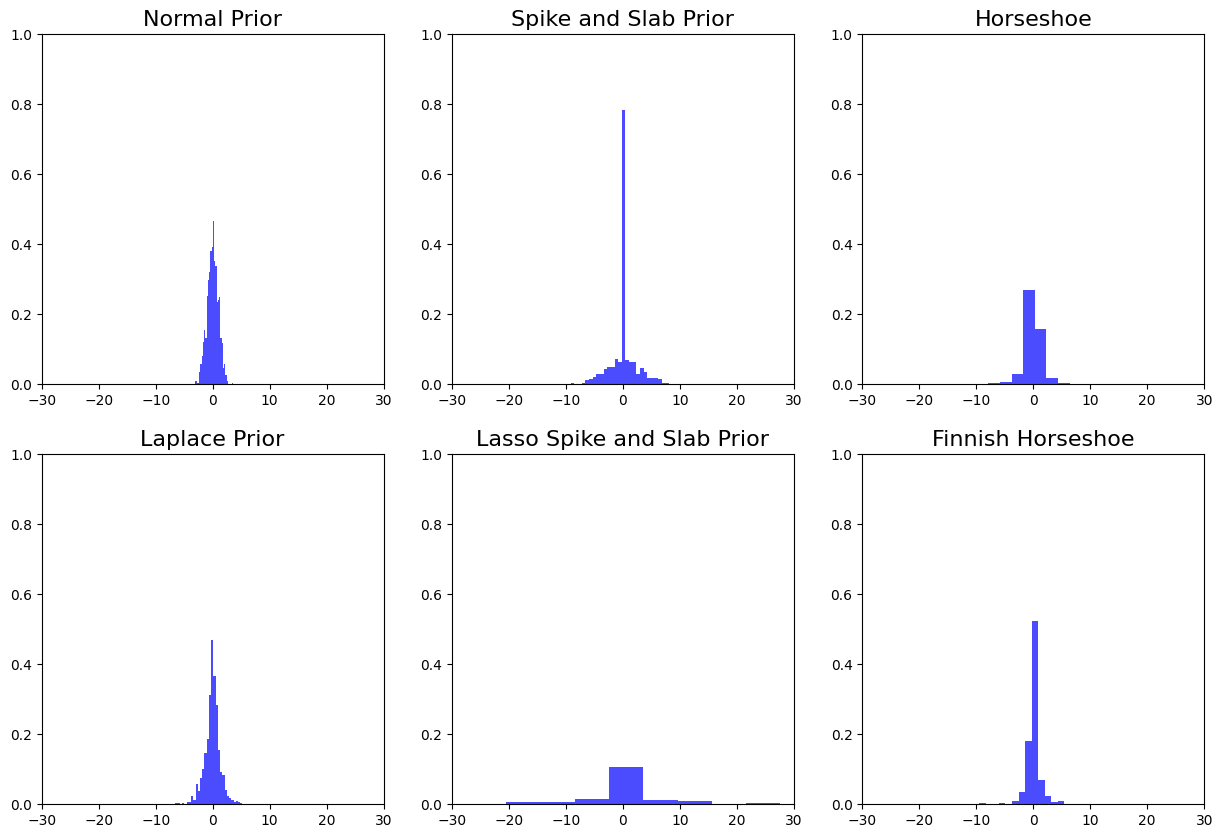

In [138]:
# Common grid
num_samples = 1000
xgrid = np.linspace(-30, 30, num_samples)

# Figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

from scipy.stats import norm, laplace, uniform, bernoulli, halfcauchy, invgamma

# Generazione di campioni Monte Carlo dalle diverse priors
tau = 1
# nelle normal scale è la deviazione standard
# mentre sopra sembra la scrittura con N(media,varianza)
# quindi qui nel codice scriviamo scale=np.sqrt(ecc)

# Normal
axes[0][0].set_title("Normal Prior", fontsize=16)
axes[0][0].set_ylim(0)
samples_normal = norm(loc=0, scale=np.sqrt(tau)).rvs(size=num_samples)
axes[0][0].hist(samples_normal,bins=30, density=True, color='blue', alpha=0.7)
axes[0][0].set_xlim(-30,30)
# Laplace
axes[1][0].set_title("Laplace Prior", fontsize=16)
axes[1][0].set_ylim(0)
samples_laplace = laplace(loc=0, scale=np.sqrt(tau)).rvs(size=num_samples)
axes[1][0].hist(samples_laplace,bins=30, density=True, color='blue', alpha=0.7)
axes[1][0].set_xlim(-30,30)

# Spike and Slab
axes[0][1].set_title("Spike and Slab Prior", fontsize=16)
axes[0][1].set_ylim(0)
tau1 = 0.01
tau2 = 10
pj_samples = bernoulli.rvs(0.5, size=num_samples)
ss_samples = pj_samples * norm(loc=0,scale=np.sqrt(tau1)).rvs(size=num_samples) +(1 - pj_samples) * norm(loc=0,scale=np.sqrt(tau2)).rvs(size=num_samples)
axes[0][1].hist(ss_samples,bins=30, density=True, color='blue', alpha=0.7)
axes[0][1].set_xlim(-30,30)

# Spike and Slab Lasso
axes[1][1].set_title("Lasso Spike and Slab Prior", fontsize=16)
axes[1][1].set_ylim(0)
tau1 = 0.01
tau2 = 10
pj_samples = bernoulli.rvs(0.5, size=num_samples)
ss_samples = pj_samples * laplace(loc=0, scale=tau1).rvs(size=num_samples) + (1 - pj_samples) * laplace(loc=0, scale=tau2).rvs(size=num_samples)
axes[1][1].hist(ss_samples,bins=30, density=True, color='blue', alpha=0.7)
axes[1][1].set_xlim(-30,30)

# Horseshoe
axes[0][2].set_title("Horseshoe", fontsize=16)
axes[0][2].set_ylim(0)
lambda_j_samples = halfcauchy(loc=0, scale=1).rvs(size=num_samples)
h_samples = norm(loc=0, scale=np.sqrt(lambda_j_samples * tau)).rvs(size=num_samples)
# Plotta l'istogramma di beta_j
axes[0][2].hist(h_samples,bins=30, density=True, color='blue', alpha=0.7)
axes[0][2].set_xlim(-30,30)


# Finnish Horseshoe
axes[1][2].set_title("Finnish Horseshoe", fontsize=16)
axes[1][2].set_ylim(0)
a = 1.0
b = 1.0
c_samples = invgamma(a, scale=b).rvs(size=num_samples)
lambda_samples = halfcauchy(loc=0, scale=1).rvs(size=num_samples)
lambda_tilde_j_squared = (c_samples**2 * lambda_j_samples**2) / (c_samples**2 + tau**2 * lambda_j_samples**2)
fh_samples = norm(loc=0, scale=np.sqrt(lambda_tilde_j_squared * tau)).rvs(size=num_samples)
axes[1][2].hist(fh_samples,bins=30, density=True, color='blue', alpha=0.7)
axes[1][2].set_xlim(-30,30)


# Show
plt.show()

For the question 2 we developed those computations on model 1 for example, which indeed showed a penalty structure.




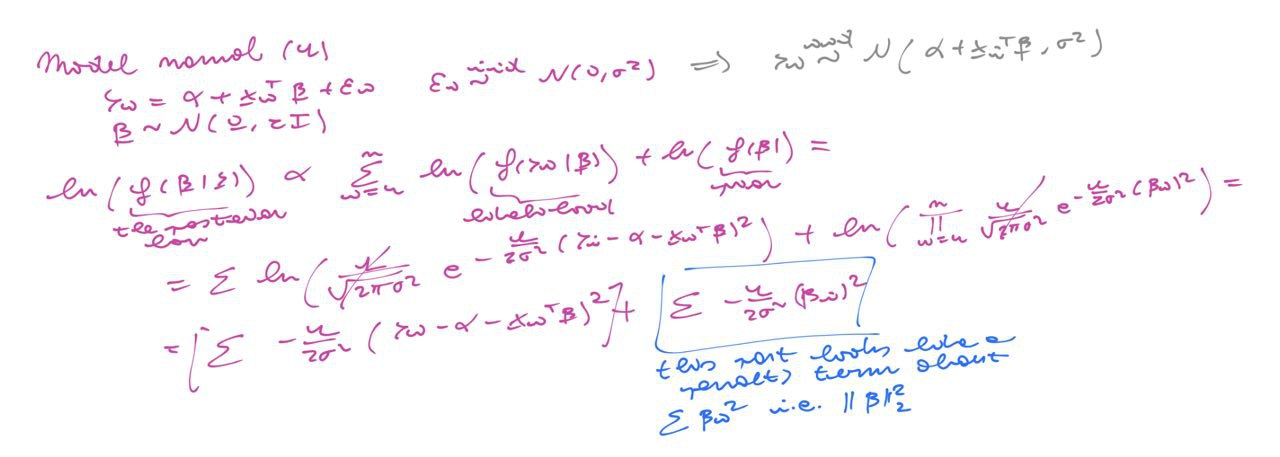

**Known penalizations**

| Prior | $-\log\pi(\beta)$ | Penalized Regression | Unit Ball |
| :-- | :-- | :-- | :-- |

**Plots - Unit Balls**

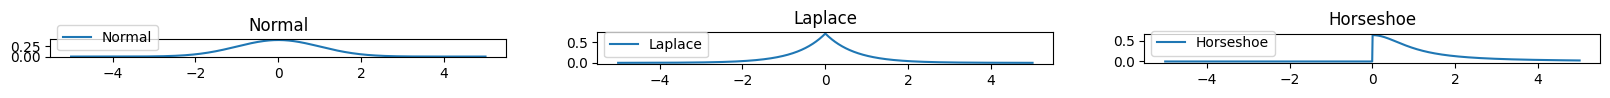

In [149]:
from scipy.stats import norm, laplace, halfcauchy

# Common grid
x = np.linspace(-5, 5, 1000)

# Figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))

# Normal
pdf_normal = norm.pdf(x, loc=0, scale=1)
axes[0].plot(x, pdf_normal, label='Normal')
axes[0].set_aspect('equal', 'box')
axes[0].set_title("Normal")
axes[0].legend()

# Laplace
pdf_laplace = laplace.pdf(x, loc=0, scale=1 / np.sqrt(2))
axes[1].plot(x, pdf_laplace, label='Laplace')
axes[1].set_aspect('equal', 'box')
axes[1].set_title("Laplace")
axes[1].legend()

# Horseshoe
pdf_horseshoe = halfcauchy.pdf(x, scale=1)
axes[2].plot(x, pdf_horseshoe, label='Horseshoe')
axes[2].set_aspect('equal', 'box')
axes[2].set_title("Horseshoe")
axes[2].legend()

# Show
plt.show()


# Exercise 2:

1) Implement the different priors in Stan and run the MCMC algorithms on the dataset.
   For priors $(1)$-$(2)$-$(5)$-$(6)$ add another level of hierarchy by assuming
   $$
       \tau \sim \mathcal{HC}(0,1)
   $$
   for the spike-and-slab priors (3)-(4) select $\tau_1$ such that $P(|\beta_j| < 0.1) > 0.25$ and $\tau_2$ such that $P(|\beta_j| > 10) >  0.25$.  
    *(Hint: $\tiny \mathbb{P}\left(|\beta_j| < 0.1 \right) = \mathbb{P}\left(|\beta_j| < 0.1 | p_j = 1\right) \mathbb{P}\left(p_j = 1\right) + \mathbb{P}\left(|\beta_j| < 0.1 | p_j = 0\right) \mathbb{P}\left(p_j = 0\right) \geq 0.5 \mathbb{P}\left(|\beta_j| < 0.1 | p_j = 1\right)$)*


2) Comment on the different results obtained. Focus in particular on:
    1. Which model gives the best predictive performance?
    2. Are there some sampling difficulties specific to some models?

In [114]:
# Data input for Stan
y = np.log(Y)
x = X
print(y.shape)
print(X.shape)
# Data input for Stan
reg_data = {
    "N": len(y),
    "P": X.shape[1],
    "y": y,
    "X": X,
    "sigma_alpha": 100,
    "sigma_eps": 0.1
}

(767,)
(767, 361)


**Normal Regression**

In [145]:
# Your code goes here
# Write stan model to file
# Compile stan model
# Your code goes here
model1_normal = """
data {
    int<lower=0> N;
    int<lower=0> P;
    array[N] real y;
    matrix[N,P] X;
    real<lower=0> sigma_alpha;
    real<lower=0> sigma_eps;
}
parameters{
    vector[P] beta;
    real<lower=0> tau;
    real alpha;
    real<lower=0> sigma;
}

model{
    // prior
    beta ~ normal(0,tau);
    tau ~ cauchy(0,1);
    alpha ~ normal(0,sigma_alpha);
    sigma ~ normal(0,sigma_eps);
    y ~ normal(alpha+X*beta,sigma);

}
"""

# Write stan model to file
stan_file = "./stan/model1_normal.stan"
with open(stan_file, "w") as f:
    print(model1_normal, file=f)

model1_normal = CmdStanModel(stan_file=stan_file)

11:01:54 - cmdstanpy - INFO - compiling stan file /tmp/tmpe8s1f2bd/tmpt8rmkntw.stan to exe file /gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model1_normal
INFO:cmdstanpy:compiling stan file /tmp/tmpe8s1f2bd/tmpt8rmkntw.stan to exe file /gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model1_normal
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=model1_normal.stan /tmp/tmpe8s1f2bd/tmpt8rmkntw
cwd: /root/.cmdstan/cmdstan-2.33.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=model1_normal.stan --o=/tmp/tmpe8s1f2bd/tmpt8rmkntw.hpp /tmp/tmpe8s1f2bd/tmpt8rmkntw.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/l

In [117]:
# Compile stan model
stan_fit = model1_normal.sample(data=reg_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)  # iter_warmup = burnin

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model1_normal info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfo5_09r7/8phvri0v.json
10:15:50 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model1_normal', 'id=2', 'random', 'seed=49016', 'data', 'file=/tmp/tmpfo5_09r7/8phvri0v.json', 'output', 'file=/tmp/tmpfo5_09r7/model1_normal70_ona4c/model1_normal-20231117101550_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model1_normal', 'id=1', 'random', 'seed=49016', 'data', 'file=/tmp/tmpfo5_09r7/8phvri0v.json', 'output', 'file=/tmp/tmpfo5_09r7/model1_normal70_ona4c/model1_normal-20231117101550_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args

10:17:45 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model1_normal', 'id=1', 'random', 'seed=49016', 'data', 'file=/tmp/tmpfo5_09r7/8phvri0v.json', 'output', 'file=/tmp/tmpfo5_09r7/model1_normal70_ona4c/model1_normal-20231117101550_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpfo5_09r7/model1_normal70_ona4c/model1_normal-20231117101550_1.csv
 console_msgs (if any):
	/tmp/tmpfo5_09r7/model1_normal70_ona4c/model1_normal-20231117101550_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (364), generating only 20 plots
  warnings.warn(


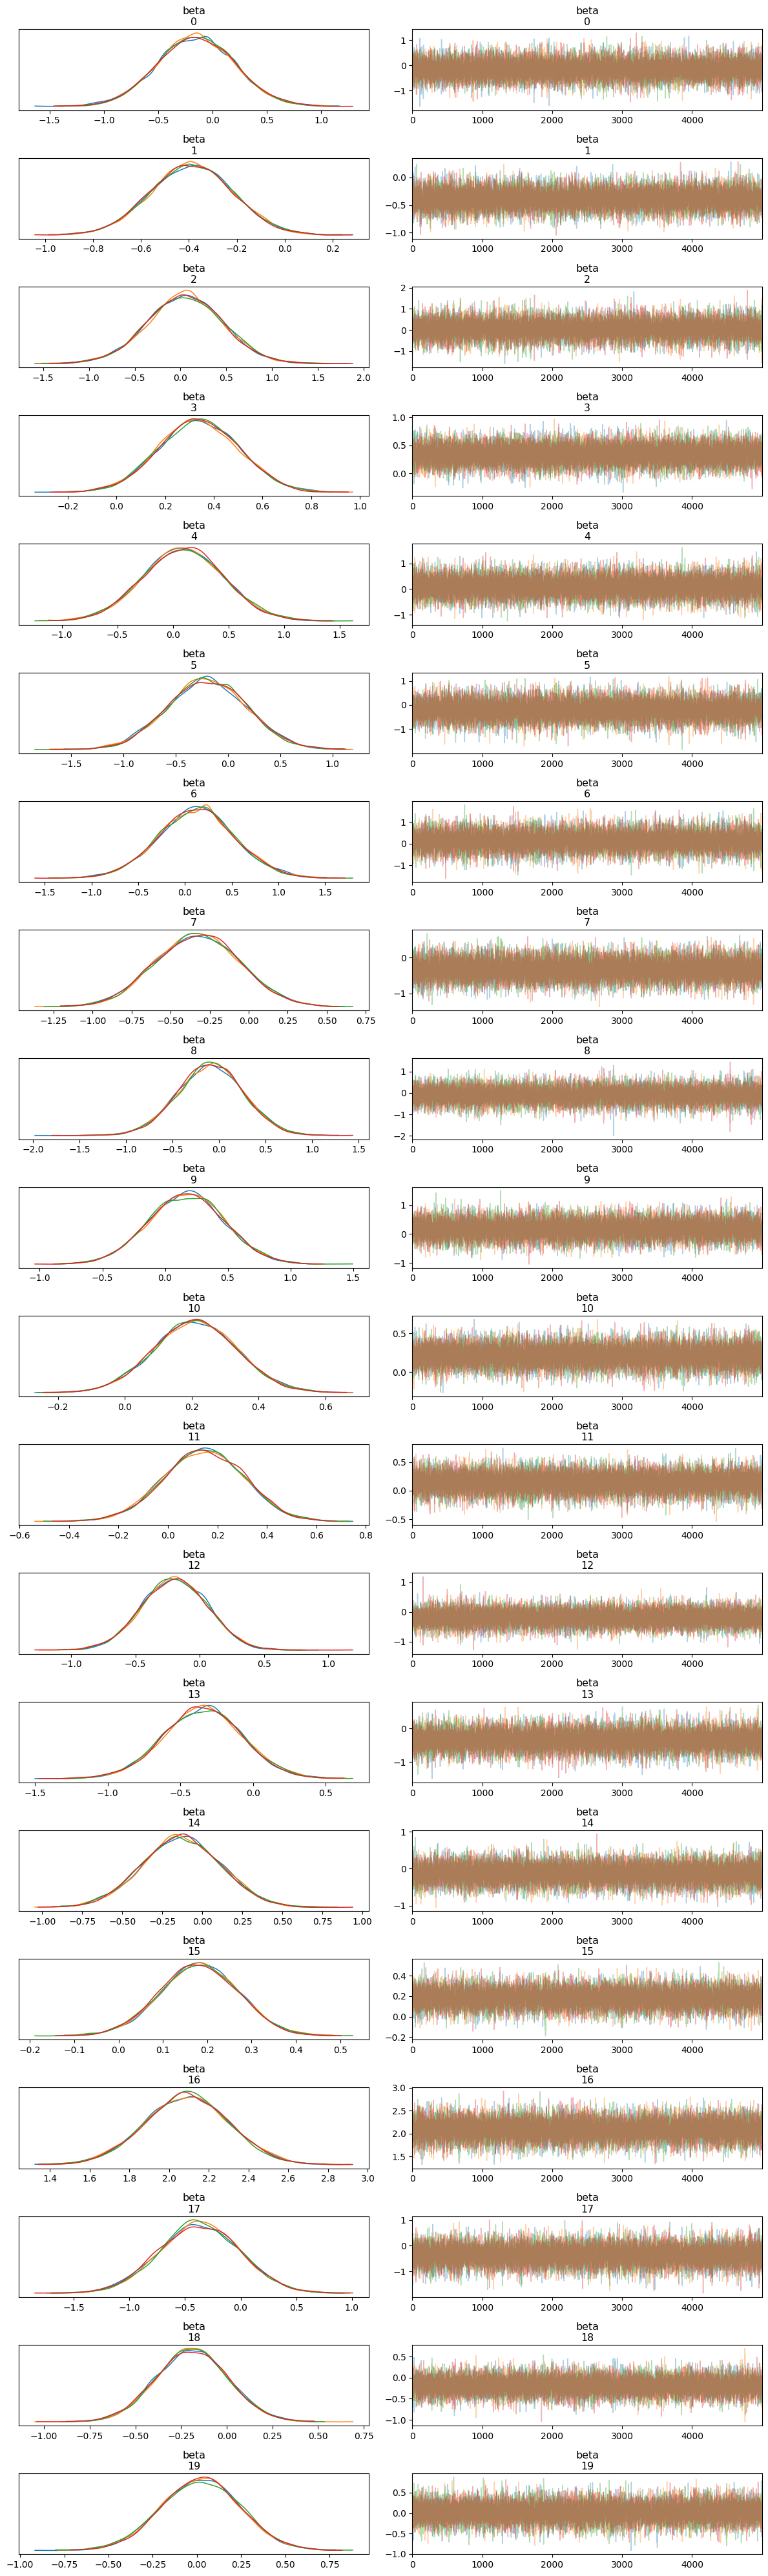

In [120]:
cmdstanpy_data = az.from_cmdstanpy(stan_fit)
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

In [ ]:
# Traceplots

**Laplace Regression**

In [144]:
# Your code goes here
model2_BayLas = """
data {
    int<lower=0> N;
    int<lower=0> P;
    array[N] real y;
    matrix[N,P] X;
    real<lower=0> sigma_alpha;
    real<lower=0> sigma_eps;
}
parameters{
    vector[P] beta;
    real<lower=0> tau;
    real alpha;
    real sigma;
}

model{
    // prior
    for (j in 1:P){
       beta[j] ~ double_exponential(0,tau);
       }
    tau ~ cauchy(0,1);
    alpha ~ normal(0,sigma_alpha);
    sigma ~ normal(0,sigma_eps);


    y ~ normal(alpha+X*beta,sigma);

}
"""

# Write stan model to file
stan_file = "./stan/model2_BayLas.stan"
with open(stan_file, "w") as f:
    print(model2_BayLas, file=f)


# Compile stan model
model2_BayLas = CmdStanModel(stan_file=stan_file)

11:01:34 - cmdstanpy - INFO - compiling stan file /tmp/tmp0_fvcoeg/tmp7fylck7t.stan to exe file /gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model2_BayLas
INFO:cmdstanpy:compiling stan file /tmp/tmp0_fvcoeg/tmp7fylck7t.stan to exe file /gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model2_BayLas
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=model2_BayLas.stan /tmp/tmp0_fvcoeg/tmp7fylck7t
cwd: /root/.cmdstan/cmdstan-2.33.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=model2_BayLas.stan --o=/tmp/tmp0_fvcoeg/tmp7fylck7t.hpp /tmp/tmp0_fvcoeg/tmp7fylck7t.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/l

In [ ]:
# Run MCMC and retrieve chains
# Compile stan model
stan_fit = model1_normal.sample(data=reg_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)  # iter_warmup = burnin

In [ ]:
# Traceplots
cmdstanpy_data = az.from_cmdstanpy(stan_fit)
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

**Spike and Slab Regression**

In [143]:
# Your code goes here
# Write stan model to file
# Compile stan model
#
model2_SSR = """
data {
    int<lower=0> N;
    int<lower=0> P;
    array[N] real y;
    matrix[N,P] X;
    real<lower=0> sigma_alpha;
    real<lower=0> sigma_eps;
    real<lower=0> tau1 ;
    real<lower=0> tau2 ;

}
parameters{
    vector[P] beta;
    real alpha;
    real<lower=0> sigma;

}

model{
    // prior
    alpha ~ normal(0,sigma_alpha);
    sigma ~ normal(0,sigma_eps);
    for (j in 1:P) {
        target += log_mix(0.5,
            normal_lpdf(beta[j] | 0, tau1),
            normal_lpdf(beta[j] | 0, tau2)
        );
    }

    // Likelihood
    y ~ normal(X * beta + alpha, sigma);
}

"""

# Write stan model to file
stan_file = "./stan/model2_SSR.stan"
with open(stan_file, "w") as f:
    print(model2_SSR, file=f)

model2_SSR = CmdStanModel(stan_file=stan_file)

11:01:13 - cmdstanpy - INFO - compiling stan file /tmp/tmp0jc8ctzh/tmpf3rcqwpv.stan to exe file /gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model2_SSR
INFO:cmdstanpy:compiling stan file /tmp/tmp0jc8ctzh/tmpf3rcqwpv.stan to exe file /gdrive/MyDrive/Colab Notebooks/Interactive T.A. 2/stan/model2_SSR
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=model2_SSR.stan /tmp/tmp0jc8ctzh/tmpf3rcqwpv
cwd: /root/.cmdstan/cmdstan-2.33.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=model2_SSR.stan --o=/tmp/tmp0jc8ctzh/tmpf3rcqwpv.hpp /tmp/tmp0jc8ctzh/tmpf3rcqwpv.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math

In [ ]:
# Run MCMC and retrieve chains
# Compile stan model
stan_fit = model1_normal.sample(data=reg_data, chains=4, parallel_chains=4,
                             iter_warmup=1000, iter_sampling=5000)  # iter_warmup = burnin

In [ ]:
# Traceplots
cmdstanpy_data = az.from_cmdstanpy(stan_fit)
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

**Spike and Slab Lasso Regression**

In [ ]:
# Your code goes here
# Write stan model to file
# Compile stan model

In [ ]:
# Run MCMC and retrieve chains

**Horseshoe Regression**

In [ ]:
# Your code goes here
# Write stan model to file
# Compile stan model

In [ ]:
# Run MCMC and retrieve chains

In [ ]:
# Traceplots

**Finnish Horseshoe Regression**

In [ ]:
# Your code goes here
# Write stan model to file
# Compile stan model

In [ ]:
# Run MCMC and retrieve chains

In [ ]:
# Traceplots

**Model Comparison**

In [ ]:
# Model dictionary
models = {
    "Normal": chains_normal,
    "Laplace": chains_laplace,
    "Spike & Slab": chains_spike_slab,
    "Spike & Slab Lasso": chains_spike_slab_lasso,
    "Horseshoe": chains_horseshoe,
    "Finnish Horseshow": chains_finnish_horseshoe
}

# Compare models via arviz

**Comments**:

## Exercise 3: Variable Selection

Given that all the priors are absolutely continuous, $\mathbb{P}(\beta_j = 0 \mid \mathbf{y}) = 0$ for all $j$.  
Hence we propose to perform variable selection using hard-shrinkages: we keep only the variables whose 95% posterior credible interval does not contain zero.

1) Implement the hard-shrinkage criterion (to get the posterior credible interval, you can use the `arviz.hdi` function)

2) Which variables are selected from the different models? Do they agree?

### Solution

In [ ]:
# Your code goes here

**Comments**:

# Exercise 4: take me to the hierarchy-land


We move on to considering the dataset with all the responses. By considering a multiple-linear model we assume

$$
    y_{ik} = \alpha + x_i^T \beta_k + \varepsilon_{ik}, \quad \varepsilon_{ik} \iid \mathcal{N}(0, \sigma^2_k)
$$

where $i$ is the index of the patient and $k$ is the index of the drug.

Of course, different models (one for each $k$) could be fitted independently, but a smarter alternative would be to model everithing jointly using a hierarchical model.

Let $\beta_k = (\beta_{k, 1}, \ldots, \beta_{k, p})$. We want to encourage a priori the following idea: if a variable (genetic mutation) is responsible for an increase (resp decrease) of the resistance to drug $k$, it is likely that il will be responsible for the resistance to other drugs as well.

Statistically, this means that if $\beta_{k, j}$ is substantially different from zero, also $\beta_{k^\prime, j}$ should be. Analogously, we can assume the opposite: if $\beta_{k, j} \approx 0$ we want to encourage $\beta_{k^\prime, j} \approx 0$.

This later idea can be easily built in a hierarchical model.

Consider for instance the spike-and-slab model

\begin{align*}
    \beta_{jk} \mid p_{jk} & \sim p_{jk} \mathcal{N}(0, \tau_1) + (1 - p_{jk}) \mathcal{N}(0, \tau_2) \\
    p_{j1}, \ldots p_{jK} \mid p_{0j} & \iid \text{Bern}(p_{j0}) \\
    p_{0j} & \iid \text{Beta}(a, b) \quad j=1, \ldots, p
\end{align*}

1) Implement the hierarchical spike and slab model in Stan and fit the whole dataset to it, considering only the responses for which the number of missing values is at maximum 100. Drop all the observations with missing values

2) Build an analogous of the hierarchical spike and slab by starting from the horseshoe prior  
   *(Hint: think about what is the role of the parameter $\lambda_j$)*

In [139]:
# Import responses
Y = pd.read_csv("Y.csv", index_col=0)
Y.head()
# Import covariates
X = pd.read_csv("X.csv", index_col=0)
X.head()
# Select first 100 rows and two drugs ("IDV", "NFV") and transform
df_4 = X
df_4['IDV'] = Y['IDV'].values
df_4['NFV'] = Y['NFV'].values
df_4 = df_4.dropna()
df_4.isna().sum()
df_4 = df_4[0:100]
df_4["IDV"] = np.log(df_4["IDV"])
df_4["NFV"] = np.log(df_4["NFV"])
df_4[["IDV", "NFV"]]
df_4

,P4.A,P12.A,P13.A,P16.A,P20.A,P22.A,P28.A,P37.A,P51.A,P54.A,...,P19.Z,P34.Z,P37.Z,P61.Z,P72.Z,P79.Z,P83.Z,P92.Z,IDV,NFV
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.487375,3.152736
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.875197,3.912023
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.484907,4.605170
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.741937,1.609438
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.605170,5.082025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.708050,3.178054
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.890372,4.204693
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.481605,1.308333
99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.230014,2.944439


In [140]:
y = df_4[["IDV","NFV"]].values
y.shape
X = df_4.values[:,0:-2]
# Data dictionary for Stan
reg_data = {
    "N": len(y),
    "P": X.shape[1],
    "K": y.shape[1],
    "y": y,
    "X": X
}

### Solution

**Hierarchical Spike and Slab Regression**

In [141]:
# Your code goes here
# Write stan model to file
# Compile stan model
spike_slab_all_param = """
data {

    int<lower=0> K; // number of variables
    int<lower=0> J; // number of groups
    int<lower=0> N; // number of observations

    real<lower=0> tau1; // hyperparameter for the spike
    real<lower=0> tau2; // hyperparameter for the slab
    real<lower=0> a; // hyperparameter for Beta distribution
    real<lower=0> b; // hyperparameter for Beta distribution
}

parameters { }

transformed parameters { }

model {
    // Priors
    for (j in 1:J) {
        p0[j] ~ beta(a, b); // prior for p0
        for (k in 1:K) {
            target += log_mix(p0[j],
                              normal_lpdf(p0[j]| 0, tau1),
                              normal_lpdf(p0[j] | 0, tau2));
        }
    }

    // Likelihood

}


"""

stan_file = "./stan/spike_slab_all_param.stan"
with open(stan_file, "w") as f:
    print(spike_slab_all_param, file=f)
stan_model = CmdStanModel(stan_file=stan_file)

ValueError: ignored

In [ ]:
# Run MCMC and retrieve chains

In [ ]:
# Traceplots (beta)

In [ ]:
# 95% Credible Intervals for beta

In [ ]:
# Traceplots (p0s)

**Hierarchical Regularised Horseshoe Regression**

In [ ]:
# Your code goes here
# Write stan model to file
# Compile stan model

In [ ]:
# Run MCMC and retrieve chains

In [ ]:
# Traceplots (beta)

In [ ]:
# 95% Credible Intervals for beta

In [ ]:
# Traceplots (lambda0)